In [1]:
import numpy as np
from numpy.typing import NDArray
from network_inputs.supervised import (
    CyclicSampler,
)
from network_inputs.unsupervised import HomogeneousPoissonSpikeDataLoader
from network_simulators.feedforward_conductance_based.simulator import (
    FeedforwardConductanceLIFNetwork,
)
from network_simulators.feedforward_current_based.simulator import (
    FeedforwardCurrentLIFNetwork,
)
from network_simulators.feedforward_conductance_based_decay_only.simulator import (
    FeedforwardConductanceLIFNetwork as FeedforwardConductanceDecayOnlyLIFNetwork,
)
import torch
from torch.utils.data import DataLoader
from torch.amp import GradScaler
from optimisation.loss_functions import (
    VanRossumLoss,
)
from parameter_loaders import StudentTrainingParams
import toml
import matplotlib.pyplot as plt
from pathlib import Path

# Type aliases for clarity
IntArray = NDArray[np.int_]
FloatArray = NDArray[np.float64]

In [2]:
# Load all network parameters from TOML file
params_file = "../parameters/train-student.toml"
with open(params_file, "r") as f:
    data = toml.load(f)
params = StudentTrainingParams(**data)

In [3]:
# Create output directory
output_dir = Path("../../dp-simulations/activity-fitting/single-neuron-debug")
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
surrgrad_scale = 10

In [5]:
# Define network
dt = 1.0
weights = np.array([[0.1]])
cell_type_indices = np.array([0])
feedforward_mask = np.array([[True]])

# Get synapse parameters and scale g_bar values by 10x
synapse_params = params.feedforward.get_synapse_params()
for param_dict in synapse_params:
    if "g_bar" in param_dict:
        param_dict["g_bar"] = param_dict["g_bar"] * 10.0

model = FeedforwardConductanceLIFNetwork(
    dt=dt,
    weights_FF=weights,
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices,
    cell_params=params.recurrent.get_cell_params(),
    cell_params_FF=params.feedforward.get_cell_params(),
    synapse_params_FF=synapse_params,
    surrgrad_scale=10,
    batch_size=1,
    optimisable=None,
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

In [6]:
# Create Poisson spike dataloader for teacher network
firing_rates = np.array([6.0])  # 6 Hz for single feedforward neuron
chunk_size = 1000.0  # 1 second chunks
n_chunks = 20  # Run for 20 seconds total

spike_dataloader = HomogeneousPoissonSpikeDataLoader(
    firing_rates=firing_rates, chunk_size=chunk_size, dt=dt, batch_size=1, device="cpu"
)

In [7]:
# Generate teacher activity by running the network with input spikes
# Enable variable tracking to collect voltages, currents, conductances in one pass
model.reset_state()
model.track_variables = True

all_input_spikes = []
all_output_spikes = []
all_voltages = []
all_currents_ff = []
all_currents_leak = []
all_conductances_ff = []

with torch.no_grad():
    for chunk_idx, (input_spikes_chunk, _) in enumerate(spike_dataloader):
        if chunk_idx >= n_chunks:
            break

        # Run one chunk through the network
        output_dict = model(input_spikes_chunk)

        # Accumulate results
        all_input_spikes.append(input_spikes_chunk)
        all_output_spikes.append(output_dict["spikes"])
        all_voltages.append(output_dict["voltages"])
        all_currents_ff.append(output_dict["currents_feedforward"])
        all_currents_leak.append(output_dict["currents_leak"])
        all_conductances_ff.append(output_dict["conductances_feedforward"])

# Concatenate all chunks along time dimension
input_spikes = torch.cat(all_input_spikes, dim=1)
output_spikes = torch.cat(all_output_spikes, dim=1)
full_voltages = torch.cat(all_voltages, dim=1)
full_currents_ff = torch.cat(all_currents_ff, dim=1)
full_currents_leak = torch.cat(all_currents_leak, dim=1)
full_conductances_ff = torch.cat(all_conductances_ff, dim=1)

model.track_variables = False

print(f"Collected {input_spikes.shape[1]} timesteps of data")
print(f"Voltages shape: {full_voltages.shape}")
print(f"Conductances shape: {full_conductances_ff.shape}")

Collected 20000 timesteps of data
Voltages shape: torch.Size([1, 20000, 1])
Conductances shape: torch.Size([1, 20000, 1, 2, 2])


In [8]:
# Create PrecomputedSpikeDataset from our teacher data
# We need to save the teacher spikes in the format the trainer expects

# Create dataset that returns input and target (teacher output) spikes
class SimpleSpikeDataset(torch.utils.data.Dataset):
    def __init__(self, input_spikes, target_spikes, chunk_size_timesteps):
        """
        Args:
            input_spikes: Tensor of shape (batch, time, neurons)
            target_spikes: Tensor of shape (batch, time, neurons)
            chunk_size_timesteps: Number of timesteps per chunk
        """
        self.input_spikes = input_spikes
        self.target_spikes = target_spikes
        self.chunk_size = chunk_size_timesteps
        self.num_chunks = input_spikes.shape[1] // chunk_size_timesteps
        self.batch_size = input_spikes.shape[0]
        self.dt = dt

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_idx = idx * self.chunk_size
        end_idx = start_idx + self.chunk_size

        input_chunk = self.input_spikes[:, start_idx:end_idx, :]
        target_chunk = self.target_spikes[:, start_idx:end_idx, :]

        return input_chunk, target_chunk


# Create dataset from our teacher data
chunk_size_timesteps = int(chunk_size)
spike_dataset = SimpleSpikeDataset(
    input_spikes=input_spikes,
    target_spikes=output_spikes,
    chunk_size_timesteps=chunk_size_timesteps,
)

# Create cyclic sampler for training
spike_dataloader = DataLoader(
    spike_dataset,
    batch_size=None,  # Already batched
    sampler=CyclicSampler(spike_dataset),
    num_workers=0,
)

print(f"Created dataset with {spike_dataset.num_chunks} chunks")
print(f"Chunk size: {chunk_size_timesteps} timesteps ({chunk_size}ms)")

Created dataset with 20 chunks
Chunk size: 1000 timesteps (1000.0ms)


In [9]:
# Create student network with different weight to train
student_weight = 0.2

# Get synapse parameters and scale g_bar values by 10x (same as teacher)
student_synapse_params = params.feedforward.get_synapse_params()
for param_dict in student_synapse_params:
    if "g_bar" in param_dict:
        param_dict["g_bar"] = param_dict["g_bar"] * 10.0

student_model = FeedforwardConductanceLIFNetwork(
    dt=dt,
    weights_FF=np.array([[student_weight]]),
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices,
    cell_params=params.recurrent.get_cell_params(),
    cell_params_FF=params.feedforward.get_cell_params(),
    synapse_params_FF=student_synapse_params,
    surrgrad_scale=params.hyperparameters.surrgrad_scale,
    batch_size=1,
    optimisable="weights",  # Make weights trainable
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

# Initialize Van Rossum loss
van_rossum_loss_fn = VanRossumLoss(
    tau=params.hyperparameters.van_rossum_tau,
    dt=dt,
    window_size=100,  # Must be integer
    device="cpu",
)

# Setup optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.05)

# Setup learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-4
)

# Mixed precision scaler (disabled for CPU)
scaler = GradScaler("cpu", enabled=False)

print(f"Student network initialized with weight: {student_weight}")
print(f"Teacher network weight: {model.weights_FF.data[0, 0].item():.3f}")
print(f"Van Rossum loss tau: {params.hyperparameters.van_rossum_tau}ms")

Student network initialized with weight: 0.2
Teacher network weight: 0.100
Van Rossum loss tau: 10.0ms


In [10]:
# Analyze gradient accumulation across increasing chunk sizes
initial_weight = 0.2
chunk_idx = 0
input_chunk, target_chunk = spike_dataset[chunk_idx]
surrgrad_scale = 5

print("Analyzing gradient accumulation with increasing chunk size")
print("=" * 70)

# Storage for results
results = []

# Run analysis with chunk sizes from 10 to 1000 in steps of 10
for chunk_size_steps in range(10, 1001, 10):
    # Create fresh model for each iteration
    fresh_model = FeedforwardConductanceLIFNetwork(
        dt=dt,
        weights_FF=np.array([[initial_weight]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=params.recurrent.get_cell_params(),
        cell_params_FF=params.feedforward.get_cell_params(),
        synapse_params_FF=student_synapse_params,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",
        feedforward_mask=feedforward_mask,
        track_variables=False,
        use_tqdm=False,
    )

    # Reset Van Rossum loss
    van_rossum_loss_fn = VanRossumLoss(
        tau=params.hyperparameters.van_rossum_tau,
        dt=dt,
        window_size=100,
        device="cpu",
    )

    # Extract subset of chunk
    input_subset = input_chunk[:, :chunk_size_steps, :]
    target_subset = target_chunk[:, :chunk_size_steps, :]

    # Run forward pass
    output_spikes = fresh_model(input_subset)

    # Compute loss
    loss = 100 * van_rossum_loss_fn(output_spikes, target_subset)

    # Compute gradients
    loss.backward()

    # Extract gradients
    log_grad = fresh_model.log_weights_FF_flat.grad.item()
    linear_weight = fresh_model.weights_FF.data[0, 0].item()
    linear_grad = log_grad * linear_weight

    # Store results
    results.append(
        {
            "chunk_size": chunk_size_steps,
            "loss": loss.item(),
            "log_grad": log_grad,
            "linear_grad": linear_grad,
        }
    )

    # Print progress every 100 steps
    if chunk_size_steps % 100 == 0:
        print(
            f"Chunk size {chunk_size_steps:4d}: loss={loss.item():.6f}, linear_grad={linear_grad:.8f}"
        )

print("\n" + "=" * 70)
print("Analysis complete!")
print("\nResults summary:")
print(f"  Chunk size range: 10 to {results[-1]['chunk_size']}")
print(f"  Number of samples: {len(results)}")
print(f"  Final loss: {results[-1]['loss']:.6f}")
print(f"  Final linear gradient: {results[-1]['linear_grad']:.8f}")

Analyzing gradient accumulation with increasing chunk size
Chunk size  100: loss=2.489051, linear_grad=64.47302823
Chunk size  200: loss=6.341773, linear_grad=434427.18884081
Chunk size  300: loss=6.066508, linear_grad=401400092924.76171875
Chunk size  400: loss=4.550051, linear_grad=178751186132000.00000000
Chunk size  500: loss=3.640041, linear_grad=143000801266086.00000000
Chunk size  600: loss=5.075968, linear_grad=19384427012218215207010304.00000000
Chunk size  700: loss=6.359951, linear_grad=331056980214217250430743421648896.00000000
Chunk size  800: loss=6.265076, linear_grad=nan
Chunk size  900: loss=5.568956, linear_grad=nan
Chunk size 1000: loss=5.360779, linear_grad=nan

Analysis complete!

Results summary:
  Chunk size range: 10 to 1000
  Number of samples: 100
  Final loss: 5.360779
  Final linear gradient: nan


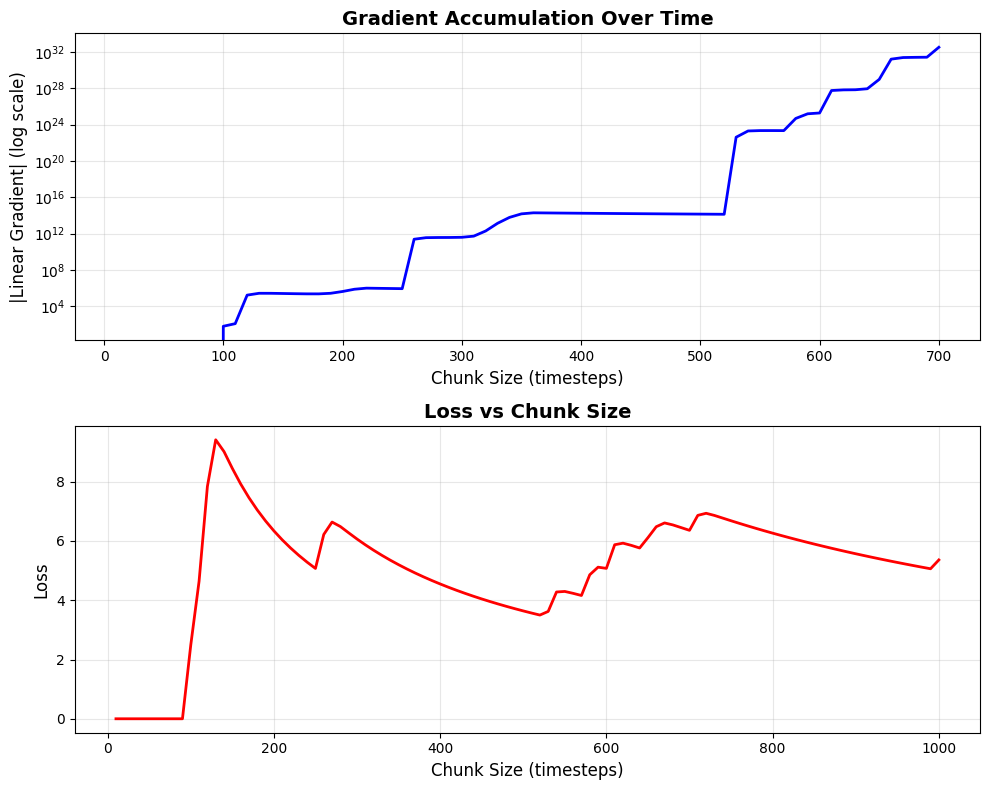


Gradient statistics:
  Min gradient: 0.00000000 at chunk size 10
  Max gradient: 331056980214217250430743421648896.00000000 at chunk size 700
  Mean gradient: nan
  Std gradient: nan


In [11]:
# Plot gradient accumulation vs chunk size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

chunk_sizes = [r["chunk_size"] for r in results]
linear_grads = [r["linear_grad"] for r in results]
losses = [r["loss"] for r in results]

# Plot linear gradient (log scale)
ax1.plot(chunk_sizes, np.abs(linear_grads), "b-", linewidth=2)
ax1.set_xlabel("Chunk Size (timesteps)", fontsize=12)
ax1.set_ylabel("|Linear Gradient| (log scale)", fontsize=12)
ax1.set_title("Gradient Accumulation Over Time", fontsize=14, fontweight="bold")
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3, which="both")

# Plot loss
ax2.plot(chunk_sizes, losses, "r-", linewidth=2)
ax2.set_xlabel("Chunk Size (timesteps)", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("Loss vs Chunk Size", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGradient statistics:")
print(
    f"  Min gradient: {min(linear_grads):.8f} at chunk size {chunk_sizes[linear_grads.index(min(linear_grads))]}"
)
print(
    f"  Max gradient: {max(linear_grads):.8f} at chunk size {chunk_sizes[linear_grads.index(max(linear_grads))]}"
)
print(f"  Mean gradient: {np.mean(linear_grads):.8f}")
print(f"  Std gradient: {np.std(linear_grads):.8f}")

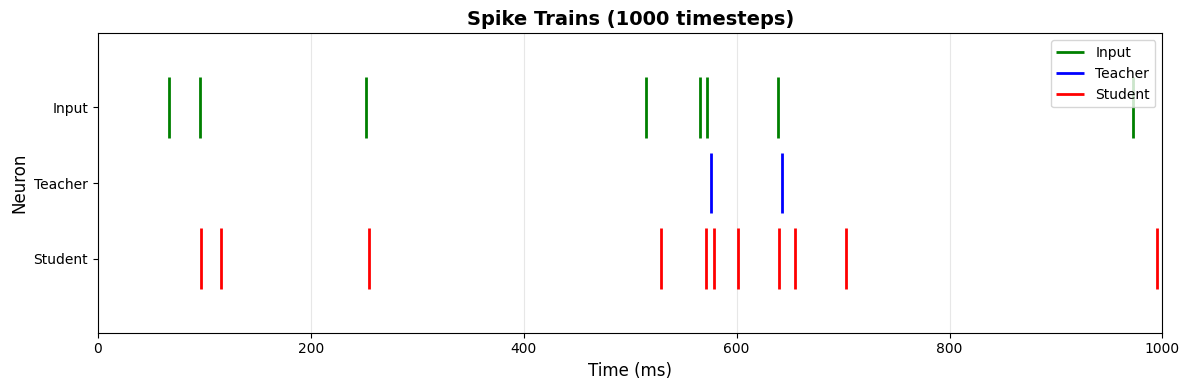

Spike statistics (first 1000 timesteps):
  Input spikes: 8
  Teacher spikes: 2
  Student spikes: 11


In [12]:
# Plot spike trains (input, teacher, student) for full 1000 timesteps
# Generate student spikes for visualization
with torch.no_grad():
    student_vis_model = FeedforwardConductanceLIFNetwork(
        dt=dt,
        weights_FF=np.array([[initial_weight]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=params.recurrent.get_cell_params(),
        cell_params_FF=params.feedforward.get_cell_params(),
        synapse_params_FF=student_synapse_params,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",
        feedforward_mask=feedforward_mask,
        track_variables=False,
        use_tqdm=False,
    )
    student_spikes_vis = student_vis_model(input_chunk)

# Extract spike times for raster plot
input_spike_times = np.where(input_chunk[0, :, 0].numpy() > 0.5)[0]
teacher_spike_times = np.where(target_chunk[0, :, 0].numpy() > 0.5)[0]
student_spike_times = np.where(student_spikes_vis[0, :, 0].numpy() > 0.5)[0]

# Create spike raster plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.eventplot(
    [input_spike_times],
    lineoffsets=2.5,
    linelengths=0.8,
    colors="green",
    linewidths=2,
    label="Input",
)
ax.eventplot(
    [teacher_spike_times],
    lineoffsets=1.5,
    linelengths=0.8,
    colors="blue",
    linewidths=2,
    label="Teacher",
)
ax.eventplot(
    [student_spike_times],
    lineoffsets=0.5,
    linelengths=0.8,
    colors="red",
    linewidths=2,
    label="Student",
)
ax.set_xlabel("Time (ms)", fontsize=12)
ax.set_ylabel("Neuron", fontsize=12)
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(["Student", "Teacher", "Input"])
ax.set_xlim(0, 1000)
ax.set_title("Spike Trains (1000 timesteps)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

print("Spike statistics (first 1000 timesteps):")
print(f"  Input spikes: {len(input_spike_times)}")
print(f"  Teacher spikes: {len(teacher_spike_times)}")
print(f"  Student spikes: {len(student_spike_times)}")

Analyzing voltage/spike/conductance gradients over time

Processing chunk size: 50
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂g|: 0.00000000
  Number of spikes: 0
  NaNs - v: 0/50, s: 0/50, g: 0/50
  Zeros - v: 50/50, s: 50/50, g: 50/50
  Non-zero non-NaN - v: 0, s: 0, g: 0

Processing chunk size: 100
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂g|: 0.00000000
  Number of spikes: 0
  NaNs - v: 0/100, s: 0/100, g: 0/100
  Zeros - v: 100/100, s: 100/100, g: 100/100
  Non-zero non-NaN - v: 0, s: 0, g: 0

Processing chunk size: 200
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂g|: 0.00000000
  Number of spikes: 0
  NaNs - v: 0/200, s: 0/200, g: 0/200
  Zeros - v: 200/200, s: 200/200, g: 200/200
  Non-zero non-NaN - v: 0, s: 0, g: 0

Processing chunk size: 500
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂g|: 0.00000000
  Number of spikes: 0
  NaNs - v:

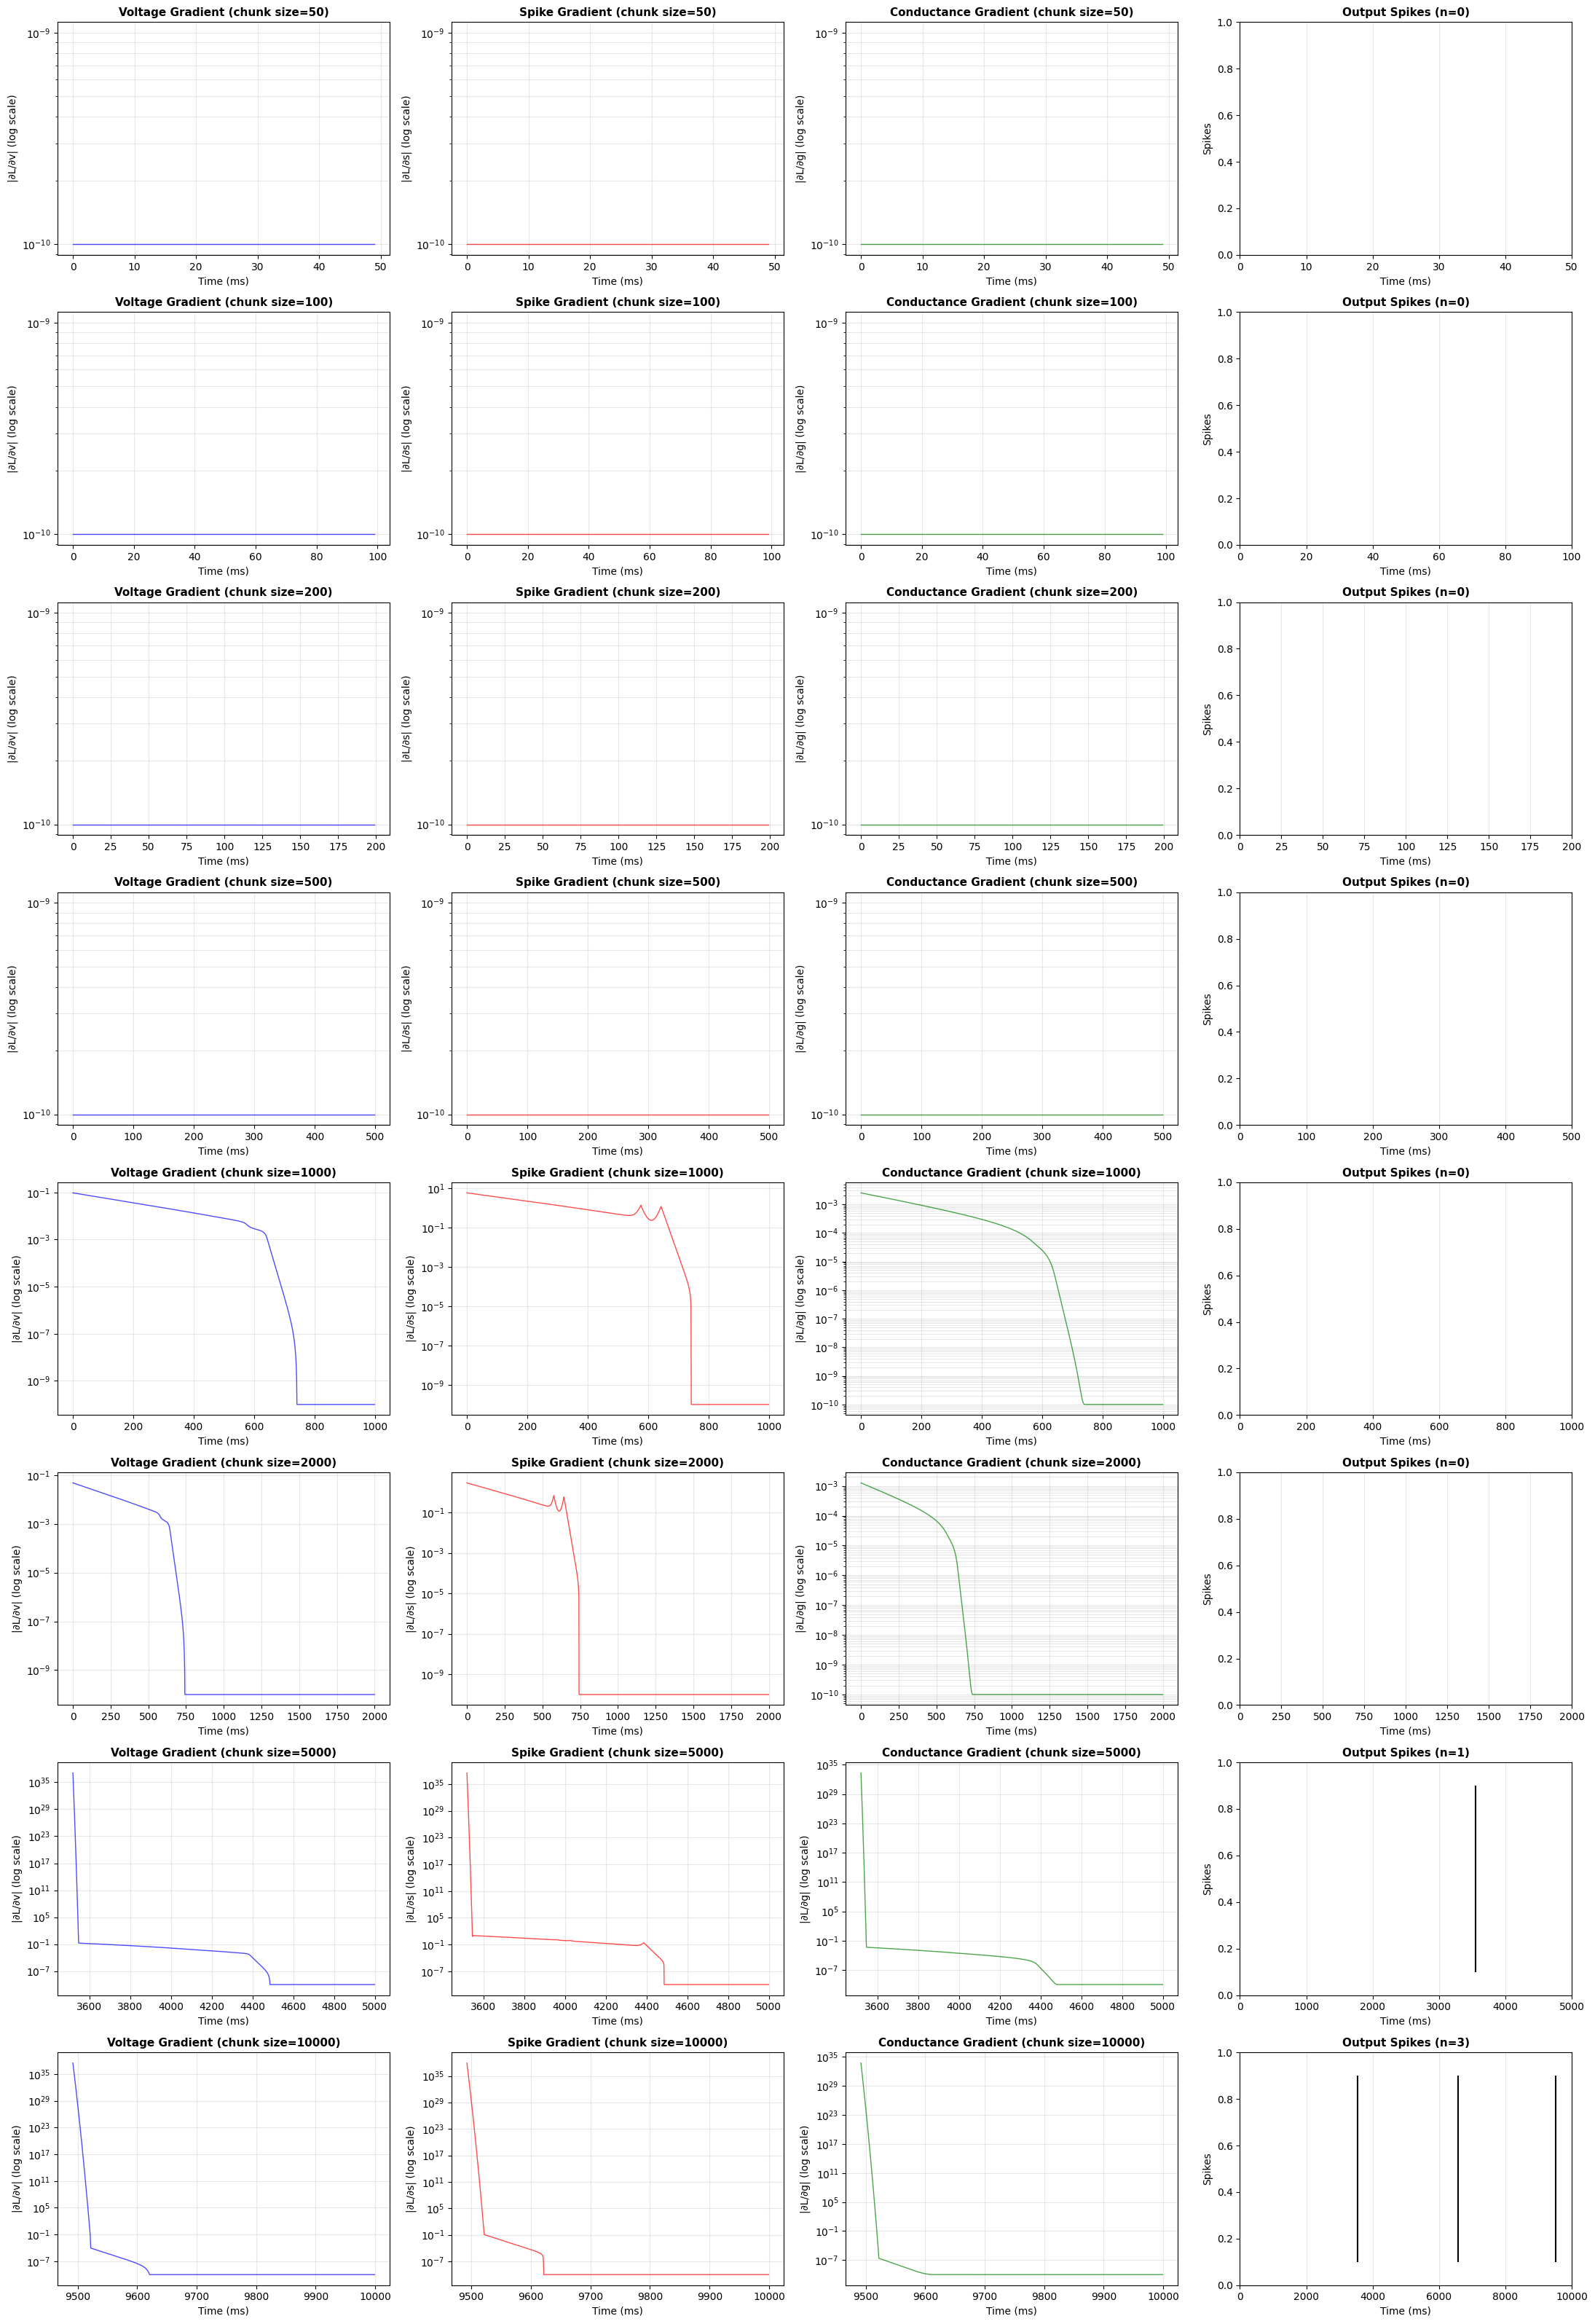


Analysis complete!


In [23]:
# Analyze voltage gradients across time for different chunk sizes
print("Analyzing voltage/spike/conductance gradients over time")
print("=" * 70)

# Test a few different chunk sizes
chunk_sizes_to_test = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

fig, axes = plt.subplots(
    len(chunk_sizes_to_test), 4, figsize=(22, 4 * len(chunk_sizes_to_test))
)

for idx, chunk_size_steps in enumerate(chunk_sizes_to_test):
    print(f"\nProcessing chunk size: {chunk_size_steps}")

    # Create fresh model for each iteration
    grad_model = FeedforwardConductanceLIFNetwork(
        dt=0.0005,
        weights_FF=np.array([[initial_weight]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=params.recurrent.get_cell_params(),
        cell_params_FF=params.feedforward.get_cell_params(),
        synapse_params_FF=student_synapse_params,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",
        feedforward_mask=feedforward_mask,
        track_variables=False,
        track_gradients=True,
        use_tqdm=False,
    )

    # Reset Van Rossum loss
    van_rossum_loss_fn = VanRossumLoss(
        tau=params.hyperparameters.van_rossum_tau,
        dt=dt,
        window_size=100,
        device="cpu",
    )

    # Get data - use multiple chunks if needed for larger sizes
    num_chunks_needed = (chunk_size_steps + 999) // 1000  # Ceiling division
    input_data_list = []
    target_data_list = []
    for chunk_idx in range(num_chunks_needed):
        if chunk_idx < len(spike_dataset):
            inp, tgt = spike_dataset[chunk_idx]
            input_data_list.append(inp)
            target_data_list.append(tgt)

    input_data = torch.cat(input_data_list, dim=1)
    target_data = torch.cat(target_data_list, dim=1)

    # Extract subset of chunk
    input_subset = input_data[:, :chunk_size_steps, :]
    target_subset = target_data[:, :chunk_size_steps, :]

    # Run forward pass with gradient tracking
    output_spikes = grad_model(input_subset)

    # Compute loss
    loss = 100 * van_rossum_loss_fn(output_spikes, target_subset)

    # Compute gradients
    loss.backward()

    # Extract tracked gradients
    grads = grad_model.get_tracked_gradients()

    # Extract voltage, spike, and conductance gradients over time
    v_grads = grads["grad_v"][:, 0, 0].cpu().numpy()
    s_grads = grads["grad_s"][:, 0, 0].cpu().numpy()
    g_grads = (
        grads["grad_g_FF"][:, 0, 0, 0, 0].cpu().numpy()
    )  # rise component, first synapse type
    spikes = output_spikes[:, :, 0].detach().cpu().numpy().flatten()
    times = np.arange(chunk_size_steps)

    # Check for NaNs
    n_nan_v = np.sum(np.isnan(v_grads))
    n_nan_s = np.sum(np.isnan(s_grads))
    n_nan_g = np.sum(np.isnan(g_grads))
    n_zero_v = np.sum(v_grads == 0)
    n_zero_s = np.sum(s_grads == 0)
    n_zero_g = np.sum(g_grads == 0)
    n_spikes = np.sum(spikes > 0.5)
    spike_times = np.where(spikes > 0.5)[0]

    # Plot voltage gradients (absolute value on log scale)
    ax = axes[idx, 0]
    ax.plot(times, np.abs(v_grads) + 1e-10, "b-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂v| (log scale)", fontsize=10)
    ax.set_title(
        f"Voltage Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot spike gradients (absolute value on log scale)
    ax = axes[idx, 1]
    ax.plot(times, np.abs(s_grads) + 1e-10, "r-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂s| (log scale)", fontsize=10)
    ax.set_title(
        f"Spike Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot conductance gradients (absolute value on log scale)
    ax = axes[idx, 2]
    ax.plot(times, np.abs(g_grads) + 1e-10, "g-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂g| (log scale)", fontsize=10)
    ax.set_title(
        f"Conductance Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot spikes
    ax = axes[idx, 3]
    if len(spike_times) > 0:
        ax.eventplot(
            [spike_times], lineoffsets=0.5, linelengths=0.8, colors="k", linewidths=1.5
        )
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("Spikes", fontsize=10)
    ax.set_title(f"Output Spikes (n={n_spikes})", fontsize=11, fontweight="bold")
    ax.set_xlim(0, chunk_size_steps)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis="x")

    print(f"  Loss: {loss.item():.6f}")
    print(f"  Max |∂L/∂v|: {np.max(np.abs(v_grads)):.8f}")
    print(f"  Max |∂L/∂s|: {np.max(np.abs(s_grads)):.8f}")
    print(f"  Max |∂L/∂g|: {np.max(np.abs(g_grads)):.8f}")
    print(f"  Number of spikes: {n_spikes}")
    print(
        f"  NaNs - v: {n_nan_v}/{len(v_grads)}, s: {n_nan_s}/{len(s_grads)}, g: {n_nan_g}/{len(g_grads)}"
    )
    print(
        f"  Zeros - v: {n_zero_v}/{len(v_grads)}, s: {n_zero_s}/{len(s_grads)}, g: {n_zero_g}/{len(g_grads)}"
    )
    print(
        f"  Non-zero non-NaN - v: {len(v_grads) - n_zero_v - n_nan_v}, s: {len(s_grads) - n_zero_s - n_nan_s}, g: {len(g_grads) - n_zero_g - n_nan_g}"
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Analysis complete!")

In [14]:
# Investigate Van Rossum loss window behavior
# Let's check what the window_size actually does

print("Investigating Van Rossum Loss Window Behavior")
print("=" * 70)

# Create a test case with known spike pattern
test_length = 500
test_student_spikes = torch.zeros(1, test_length, 1)
test_target_spikes = torch.zeros(1, test_length, 1)

# Put a single spike at different positions and see how loss changes
test_loss_fn = VanRossumLoss(
    tau=params.hyperparameters.van_rossum_tau,
    dt=dt,
    window_size=100,
    device="cpu",
)

losses_by_position = []
for spike_pos in range(50, test_length - 50, 50):
    # Reset spikes
    test_student_spikes.zero_()
    test_target_spikes.zero_()

    # Add spike at position for student (but not target)
    test_student_spikes[0, spike_pos, 0] = 1.0

    # Compute loss
    test_loss_fn.__init__(
        tau=params.hyperparameters.van_rossum_tau, dt=dt, window_size=100, device="cpu"
    )
    loss = test_loss_fn(test_student_spikes, test_target_spikes)

    losses_by_position.append({"position": spike_pos, "loss": loss.item()})
    print(f"Spike at position {spike_pos}: loss = {loss.item():.6f}")

# Now test: does window_size mean "only last N timesteps" or "sliding window"?
print("\n" + "=" * 70)
print("Testing window behavior: early vs late spike")

# Early spike (position 50)
test_student_spikes.zero_()
test_target_spikes.zero_()
test_student_spikes[0, 50, 0] = 1.0
test_loss_fn.__init__(
    tau=params.hyperparameters.van_rossum_tau, dt=dt, window_size=100, device="cpu"
)
loss_early = test_loss_fn(test_student_spikes, test_target_spikes)

# Late spike (position 450)
test_student_spikes.zero_()
test_target_spikes.zero_()
test_student_spikes[0, 450, 0] = 1.0
test_loss_fn.__init__(
    tau=params.hyperparameters.van_rossum_tau, dt=dt, window_size=100, device="cpu"
)
loss_late = test_loss_fn(test_student_spikes, test_target_spikes)

print(f"\nEarly spike (t=50): loss = {loss_early.item():.6f}")
print(f"Late spike (t=450): loss = {loss_late.item():.6f}")
print(f"Ratio (late/early): {loss_late.item() / loss_early.item():.4f}")

if abs(loss_late.item() - loss_early.item()) < 0.0001:
    print("\n✓ Window appears to be SLIDING (equal contribution)")
else:
    print("\n✗ Window appears to only consider FINAL timesteps")
    print("  This would explain decreasing gradients!")

Investigating Van Rossum Loss Window Behavior
Spike at position 50: loss = 0.011033
Spike at position 100: loss = 0.011033
Spike at position 150: loss = 0.011033
Spike at position 200: loss = 0.011033
Spike at position 250: loss = 0.011033
Spike at position 300: loss = 0.011033
Spike at position 350: loss = 0.011033
Spike at position 400: loss = 0.011033

Testing window behavior: early vs late spike

Early spike (t=50): loss = 0.011033
Late spike (t=450): loss = 0.011033
Ratio (late/early): 1.0000

✓ Window appears to be SLIDING (equal contribution)


# Current-Based Model Gradient Analysis

Now let's perform the same gradient analysis for the current-based feedforward model.

In [15]:
# Create current-based teacher network (same weight as conductance-based for comparison)
weights_current = np.array([[0.1]])
cell_type_indices_current = np.array([0])
feedforward_mask_current = np.array([[True]])

# Create synapse parameters for current-based model
# Current-based requires: tau_syn (time constant) and type (excitatory/inhibitory)
synapse_params_current = [
    {
        "name": "excitatory",
        "synapse_id": 0,
        "cell_id": 0,
        "tau_syn": 5.0,  # ms - synaptic time constant
        "type": "excitatory",
    }
]

model_current = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=weights_current,
    cell_type_indices=cell_type_indices_current,
    cell_type_indices_FF=cell_type_indices_current,
    cell_params=params.recurrent.get_cell_params(),
    synapse_params_FF=synapse_params_current,
    surrgrad_scale=10,
    batch_size=1,
    optimisable=None,
    feedforward_mask=feedforward_mask_current,
    track_variables=False,
    use_tqdm=False,
)

print("Current-based model initialized")
print(f"Weight: {model_current.weights_FF[0, 0]:.3f}")

Current-based model initialized
Weight: 0.100


In [16]:
# Generate teacher activity for current-based model
model_current.reset_state()
model_current.track_variables = True

all_input_spikes_current = []
all_output_spikes_current = []
all_voltages_current = []
all_currents_syn_current = []

with torch.no_grad():
    for chunk_idx, (input_spikes_chunk, _) in enumerate(spike_dataloader):
        if chunk_idx >= n_chunks:
            break

        # Run one chunk through the network
        output_dict = model_current(input_spikes_chunk)

        # Accumulate results
        all_input_spikes_current.append(input_spikes_chunk)
        all_output_spikes_current.append(output_dict["spikes"])
        all_voltages_current.append(output_dict["voltages"])
        all_currents_syn_current.append(output_dict["currents_syn"])

# Concatenate all chunks along time dimension
input_spikes_current = torch.cat(all_input_spikes_current, dim=1)
output_spikes_current = torch.cat(all_output_spikes_current, dim=1)
full_voltages_current = torch.cat(all_voltages_current, dim=1)
full_currents_syn_current = torch.cat(all_currents_syn_current, dim=1)

model_current.track_variables = False

print(f"Collected {input_spikes_current.shape[1]} timesteps of data")
print(f"Voltages shape: {full_voltages_current.shape}")
print(f"Currents shape: {full_currents_syn_current.shape}")

Collected 20000 timesteps of data
Voltages shape: torch.Size([1, 20000, 1])
Currents shape: torch.Size([1, 20000, 1, 1])


In [17]:
# Create dataset from current-based teacher data
spike_dataset_current = SimpleSpikeDataset(
    input_spikes=input_spikes_current,
    target_spikes=output_spikes_current,
    chunk_size_timesteps=chunk_size_timesteps,
)

print(f"Created current-based dataset with {spike_dataset_current.num_chunks} chunks")
print(f"Chunk size: {chunk_size_timesteps} timesteps ({chunk_size}ms)")

Created current-based dataset with 20 chunks
Chunk size: 1000 timesteps (1000.0ms)


Analyzing voltage/spike/current gradients over time (CURRENT-BASED MODEL)

Processing chunk size: 50
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂I_syn|: 0.00000000
  Number of spikes: 0
  NaNs - v: 0/50, s: 0/50, I: 0/50
  Zeros - v: 50/50, s: 50/50, I: 50/50
  Non-zero non-NaN - v: 0, s: 0, I: 0

Processing chunk size: 100
  Loss: 2.489051
  Max |∂L/∂v|: 17.64925194
  Max |∂L/∂s|: 4.97810173
  Max |∂L/∂I_syn|: 93.56621552
  Number of spikes: 1
  NaNs - v: 0/100, s: 0/100, I: 0/100
  Zeros - v: 1/100, s: 1/100, I: 1/100
  Non-zero non-NaN - v: 99, s: 99, I: 99

Processing chunk size: 200
  Loss: 2.758328
  Max |∂L/∂v|: 19.55862999
  Max |∂L/∂s|: 5.51665545
  Max |∂L/∂I_syn|: 103.74545288
  Number of spikes: 1
  NaNs - v: 0/200, s: 0/200, I: 0/200
  Zeros - v: 4/200, s: 4/200, I: 4/200
  Non-zero non-NaN - v: 196, s: 196, I: 196

Processing chunk size: 500
  Loss: 2.206662
  Max |∂L/∂v|: 7.82345247
  Max |∂L/∂s|: 2.20666218
  Max |∂L/∂I_syn|: 41.52249

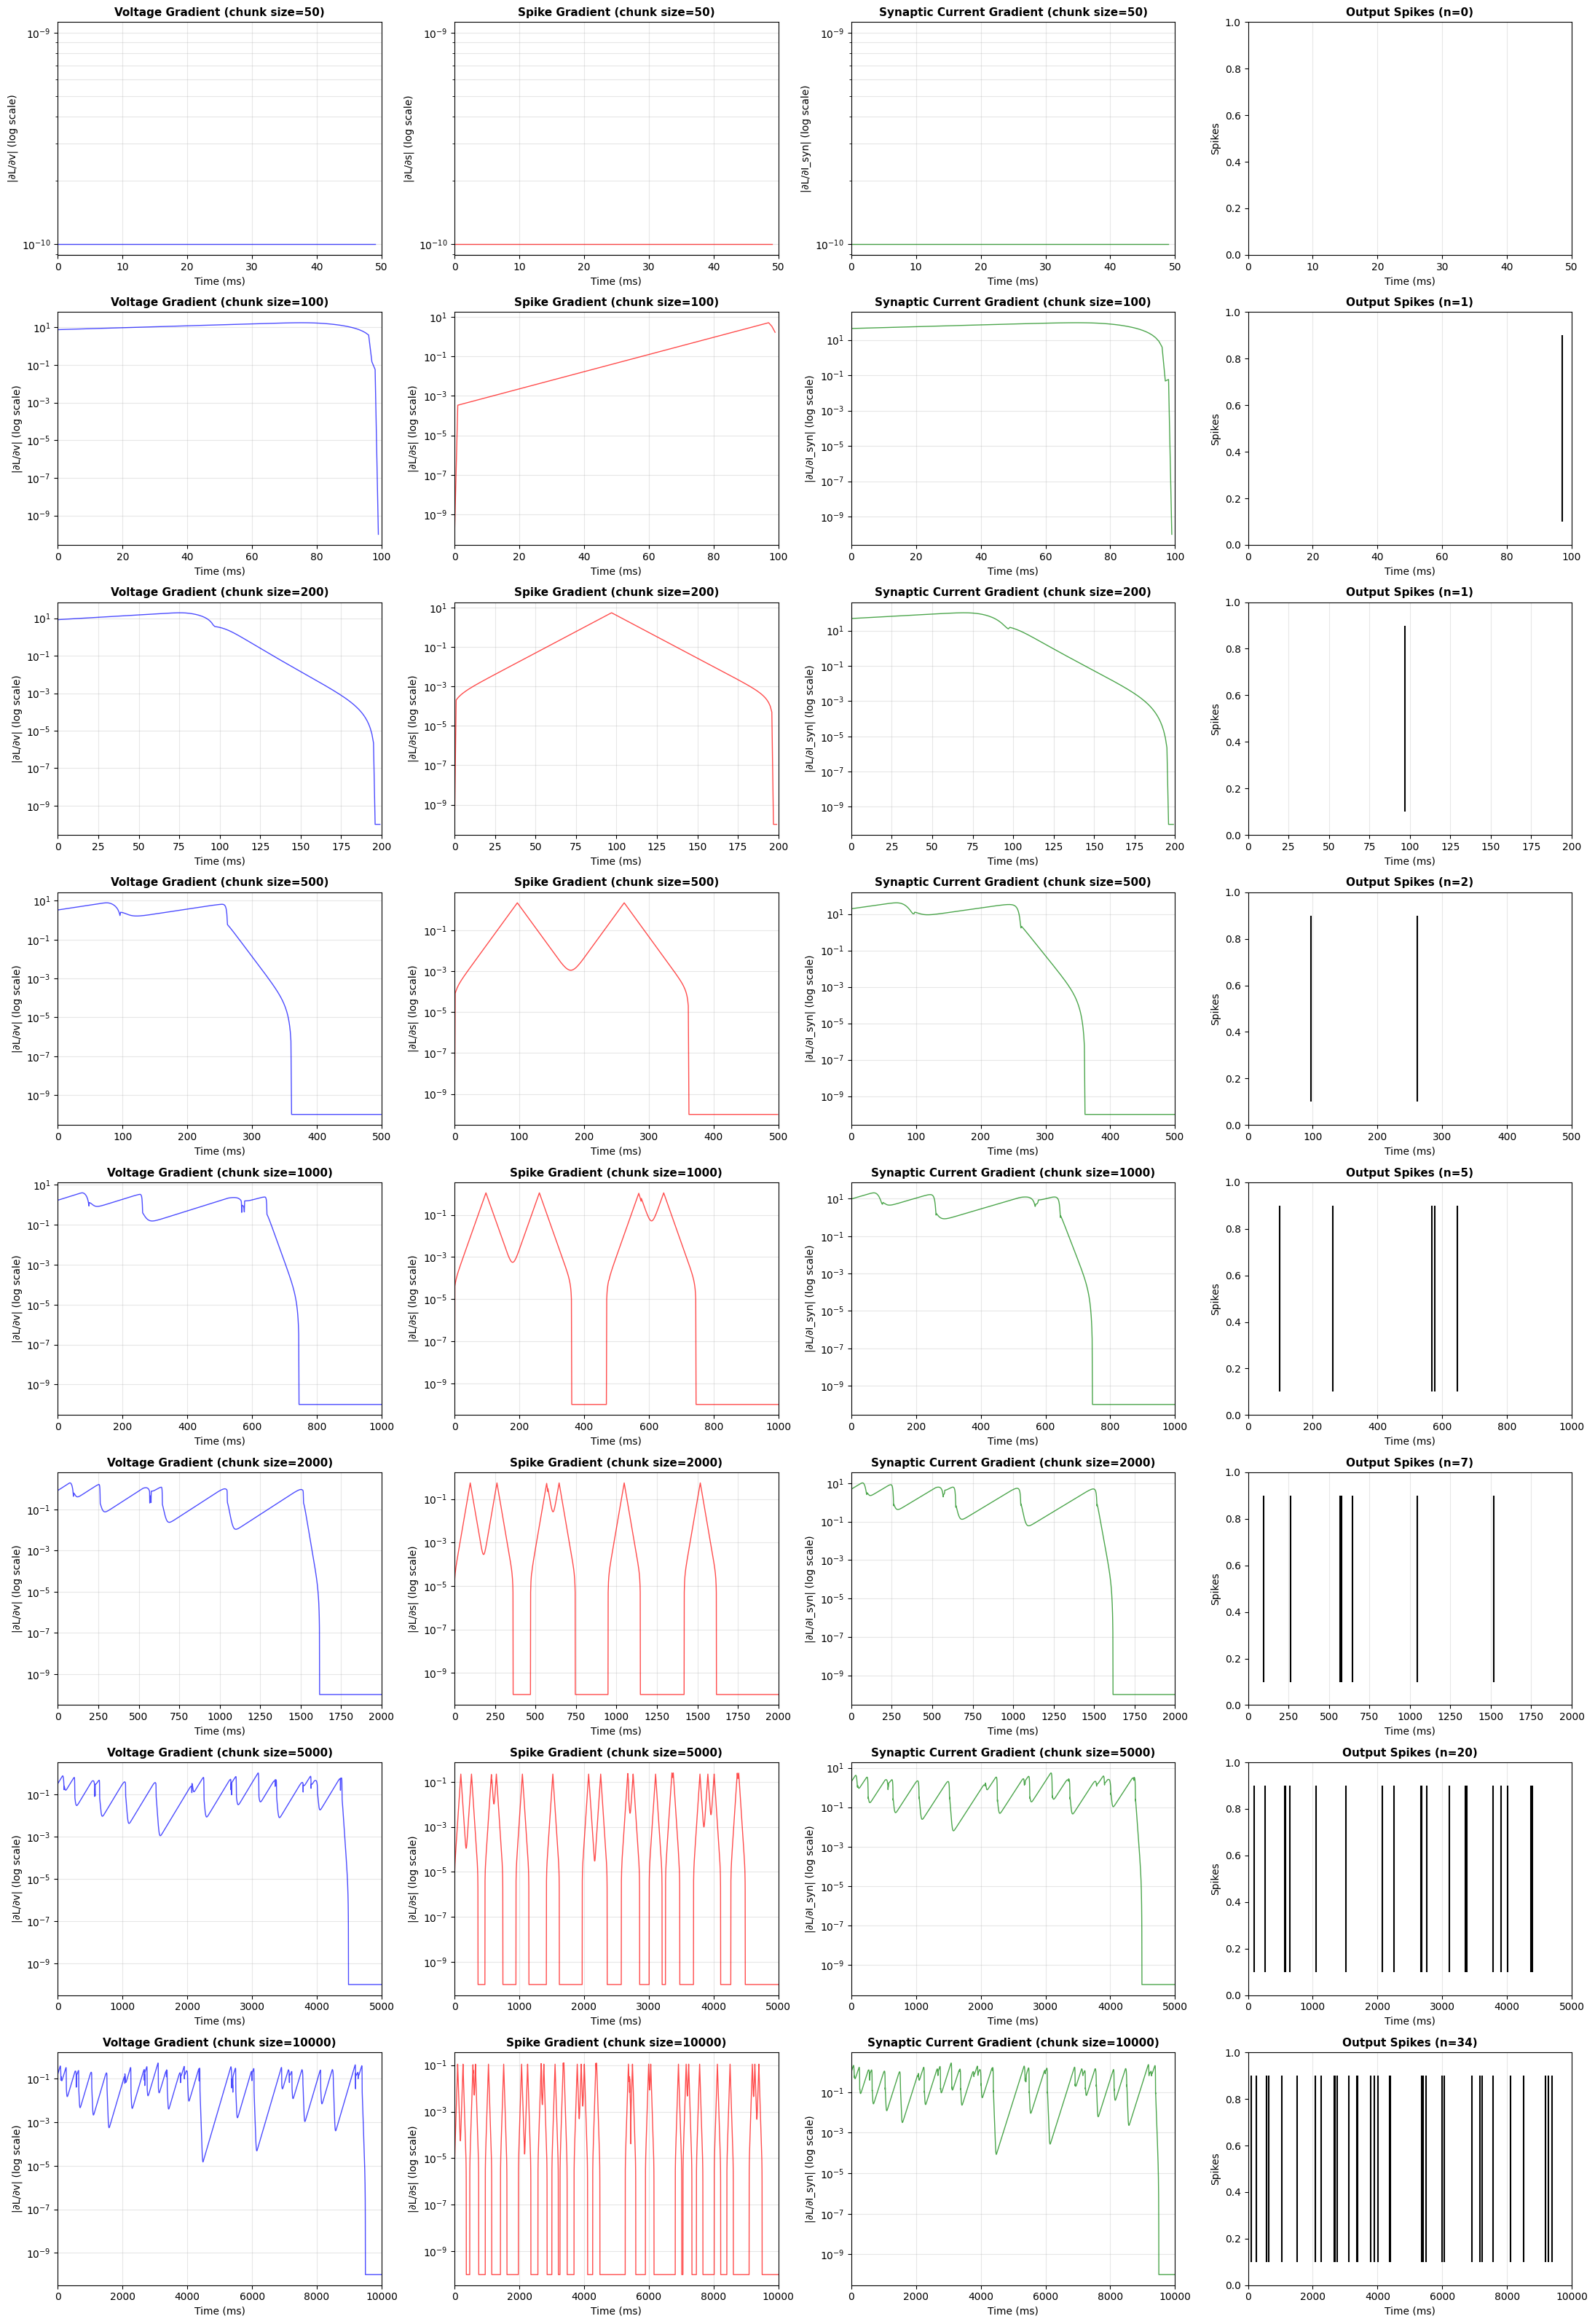


Analysis complete!


In [18]:
# Analyze voltage/spike/current gradients for current-based model across time
print("Analyzing voltage/spike/current gradients over time (CURRENT-BASED MODEL)")
print("=" * 70)

# Test a few different chunk sizes
chunk_sizes_to_test_current = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

fig, axes = plt.subplots(
    len(chunk_sizes_to_test_current),
    4,
    figsize=(22, 4 * len(chunk_sizes_to_test_current)),
)

for idx, chunk_size_steps in enumerate(chunk_sizes_to_test_current):
    print(f"\nProcessing chunk size: {chunk_size_steps}")

    # Create fresh model for each iteration
    grad_model_current = FeedforwardCurrentLIFNetwork(
        dt=dt,
        weights_FF=np.array([[initial_weight]]),
        cell_type_indices=cell_type_indices_current,
        cell_type_indices_FF=cell_type_indices_current,
        cell_params=params.recurrent.get_cell_params(),
        synapse_params_FF=synapse_params_current,
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",
        feedforward_mask=feedforward_mask_current,
        track_variables=False,
        track_gradients=True,
        use_tqdm=False,
    )

    # Reset Van Rossum loss
    van_rossum_loss_fn = VanRossumLoss(
        tau=params.hyperparameters.van_rossum_tau,
        dt=dt,
        window_size=100,
        device="cpu",
    )

    # Get data - use multiple chunks if needed for larger sizes
    num_chunks_needed = (chunk_size_steps + 999) // 1000  # Ceiling division
    input_data_list = []
    target_data_list = []
    for chunk_idx in range(num_chunks_needed):
        if chunk_idx < len(spike_dataset_current):
            inp, tgt = spike_dataset_current[chunk_idx]
            input_data_list.append(inp)
            target_data_list.append(tgt)

    input_data = torch.cat(input_data_list, dim=1)
    target_data = torch.cat(target_data_list, dim=1)

    # Extract subset of chunk
    input_subset = input_data[:, :chunk_size_steps, :]
    target_subset = target_data[:, :chunk_size_steps, :]

    # Run forward pass with gradient tracking
    output_spikes = grad_model_current(input_subset)

    # Compute loss
    loss = 100 * van_rossum_loss_fn(output_spikes, target_subset)

    # Compute gradients
    loss.backward()

    # Extract tracked gradients
    grads = grad_model_current.get_tracked_gradients()

    # Extract voltage, spike, and current gradients over time
    v_grads = grads["grad_v"][:, 0, 0].cpu().numpy()
    s_grads = grads["grad_s"][:, 0, 0].cpu().numpy()
    I_grads = grads["grad_I_syn"][:, 0, 0, 0].cpu().numpy()  # first synapse type
    spikes = output_spikes[:, :, 0].detach().cpu().numpy().flatten()
    times = np.arange(chunk_size_steps)

    # Check for NaNs
    n_nan_v = np.sum(np.isnan(v_grads))
    n_nan_s = np.sum(np.isnan(s_grads))
    n_nan_I = np.sum(np.isnan(I_grads))
    n_zero_v = np.sum(v_grads == 0)
    n_zero_s = np.sum(s_grads == 0)
    n_zero_I = np.sum(I_grads == 0)
    n_spikes = np.sum(spikes > 0.5)
    spike_times = np.where(spikes > 0.5)[0]

    # Plot voltage gradients (absolute value on log scale)
    ax = axes[idx, 0]
    ax.plot(times, np.abs(v_grads) + 1e-10, "b-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂v| (log scale)", fontsize=10)
    ax.set_title(
        f"Voltage Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")
    ax.set_xlim(0, chunk_size_steps)

    # Plot spike gradients (absolute value on log scale)
    ax = axes[idx, 1]
    ax.plot(times, np.abs(s_grads) + 1e-10, "r-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂s| (log scale)", fontsize=10)
    ax.set_title(
        f"Spike Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")
    ax.set_xlim(0, chunk_size_steps)

    # Plot synaptic current gradients (absolute value on log scale)
    ax = axes[idx, 2]
    ax.plot(times, np.abs(I_grads) + 1e-10, "g-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂I_syn| (log scale)", fontsize=10)
    ax.set_title(
        f"Synaptic Current Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")
    ax.set_xlim(0, chunk_size_steps)

    # Plot spikes
    ax = axes[idx, 3]
    if len(spike_times) > 0:
        ax.eventplot(
            [spike_times], lineoffsets=0.5, linelengths=0.8, colors="k", linewidths=1.5
        )
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("Spikes", fontsize=10)
    ax.set_title(f"Output Spikes (n={n_spikes})", fontsize=11, fontweight="bold")
    ax.set_xlim(0, chunk_size_steps)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis="x")

    print(f"  Loss: {loss.item():.6f}")
    print(f"  Max |∂L/∂v|: {np.max(np.abs(v_grads)):.8f}")
    print(f"  Max |∂L/∂s|: {np.max(np.abs(s_grads)):.8f}")
    print(f"  Max |∂L/∂I_syn|: {np.max(np.abs(I_grads)):.8f}")
    print(f"  Number of spikes: {n_spikes}")
    print(
        f"  NaNs - v: {n_nan_v}/{len(v_grads)}, s: {n_nan_s}/{len(s_grads)}, I: {n_nan_I}/{len(I_grads)}"
    )
    print(
        f"  Zeros - v: {n_zero_v}/{len(v_grads)}, s: {n_zero_s}/{len(s_grads)}, I: {n_zero_I}/{len(I_grads)}"
    )
    print(
        f"  Non-zero non-NaN - v: {len(v_grads) - n_zero_v - n_nan_v}, s: {len(s_grads) - n_zero_s - n_nan_s}, I: {len(I_grads) - n_zero_I - n_nan_I}"
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Analysis complete!")

Direct comparison: Spike gradients with identical inputs


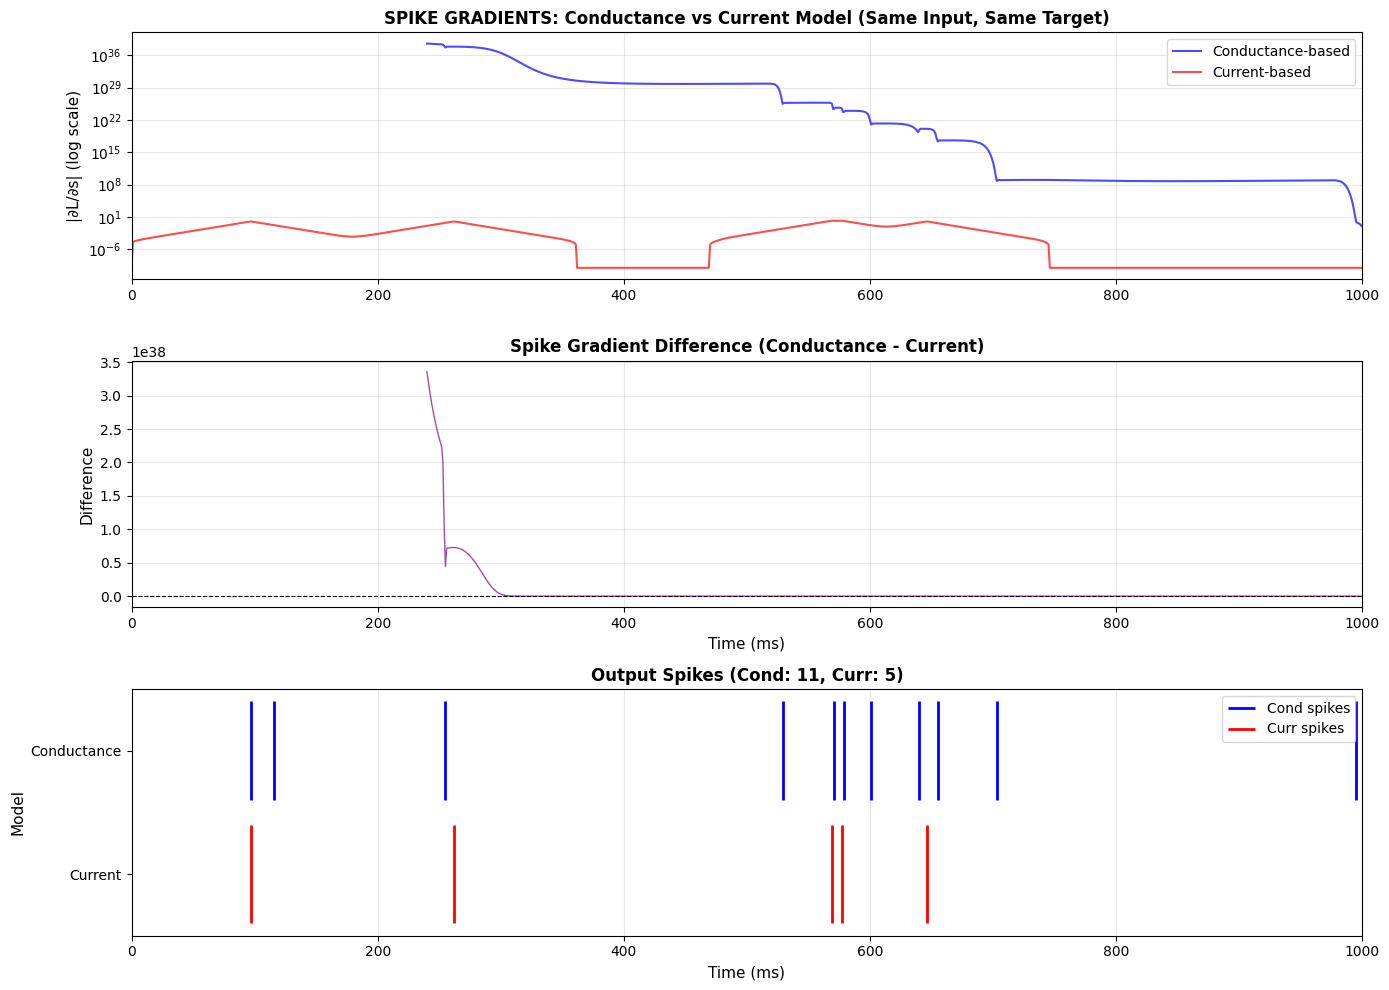


Conductance model:
  Loss: 7.017116
  Max |∂L/∂s|: nan
  Mean |∂L/∂s|: nan
  Spikes: 11

Current model:
  Loss: 3.255691
  Max |∂L/∂s|: 1.60019946
  Mean |∂L/∂s|: 0.11041495
  Spikes: 5

Difference:
  Max |difference|: nan
  Ratio (max cond / max curr): nanx


/tungstenfs/scratch/gzenke/bedfrory/connectome-snns/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [19]:
# Compare spike gradients directly between conductance and current models
# Use the SAME input spikes to isolate the backprop difference
print("Direct comparison: Spike gradients with identical inputs")
print("=" * 70)

chunk_size_test = 1000

# Use SAME input spikes for both models
input_test, _ = spike_dataset[0]

# Conductance model
grad_model_cond = FeedforwardConductanceLIFNetwork(
    dt=dt,
    weights_FF=np.array([[initial_weight]]),
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices,
    cell_params=params.recurrent.get_cell_params(),
    cell_params_FF=params.feedforward.get_cell_params(),
    synapse_params_FF=student_synapse_params,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable="weights",
    feedforward_mask=feedforward_mask,
    track_gradients=True,
    use_tqdm=False,
)

# Current model
grad_model_curr = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=np.array([[initial_weight]]),
    cell_type_indices=cell_type_indices_current,
    cell_type_indices_FF=cell_type_indices_current,
    cell_params=params.recurrent.get_cell_params(),
    synapse_params_FF=synapse_params_current,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable="weights",
    feedforward_mask=feedforward_mask_current,
    track_gradients=True,
    use_tqdm=False,
)

# SAME input for both
out_cond = grad_model_cond(input_test)
out_curr = grad_model_curr(input_test)

# Create IDENTICAL target (zeros - worst case for gradient magnitude)
target_zeros = torch.zeros_like(out_cond)

# Compute losses with IDENTICAL targets
loss_fn = VanRossumLoss(
    tau=params.hyperparameters.van_rossum_tau, dt=dt, window_size=100, device="cpu"
)
loss_cond = 100 * loss_fn(out_cond, target_zeros)

loss_fn = VanRossumLoss(
    tau=params.hyperparameters.van_rossum_tau, dt=dt, window_size=100, device="cpu"
)
loss_curr = 100 * loss_fn(out_curr, target_zeros)

# Backward
loss_cond.backward()
loss_curr.backward()

# Extract spike gradients
grads_cond = grad_model_cond.get_tracked_gradients()
grads_curr = grad_model_curr.get_tracked_gradients()

s_grads_cond = grads_cond["grad_s"][:, 0, 0].cpu().numpy()
s_grads_curr = grads_curr["grad_s"][:, 0, 0].cpu().numpy()

# Get spike times
spikes_cond = out_cond[:, :, 0].detach().cpu().numpy().flatten()
spikes_curr = out_curr[:, :, 0].detach().cpu().numpy().flatten()

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Spike gradients comparison
ax = axes[0]
times = np.arange(len(s_grads_cond))
ax.plot(
    times,
    np.abs(s_grads_cond) + 1e-10,
    "b-",
    alpha=0.7,
    linewidth=1.5,
    label="Conductance-based",
)
ax.plot(
    times,
    np.abs(s_grads_curr) + 1e-10,
    "r-",
    alpha=0.7,
    linewidth=1.5,
    label="Current-based",
)
ax.set_yscale("log")
ax.set_ylabel("|∂L/∂s| (log scale)", fontsize=11)
ax.set_title(
    "SPIKE GRADIENTS: Conductance vs Current Model (Same Input, Same Target)",
    fontsize=12,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1000)

# Difference
ax = axes[1]
ax.plot(times, s_grads_cond - s_grads_curr, "purple", alpha=0.7, linewidth=1)
ax.set_ylabel("Difference", fontsize=11)
ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_title(
    "Spike Gradient Difference (Conductance - Current)", fontsize=12, fontweight="bold"
)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
ax.set_xlim(0, 1000)

# Show which model produced spikes where
ax = axes[2]
spike_times_cond = np.where(spikes_cond > 0.5)[0]
spike_times_curr = np.where(spikes_curr > 0.5)[0]
if len(spike_times_cond) > 0:
    ax.eventplot(
        [spike_times_cond],
        lineoffsets=1.5,
        linelengths=0.8,
        colors="blue",
        linewidths=2,
        label="Cond spikes",
    )
if len(spike_times_curr) > 0:
    ax.eventplot(
        [spike_times_curr],
        lineoffsets=0.5,
        linelengths=0.8,
        colors="red",
        linewidths=2,
        label="Curr spikes",
    )
ax.set_xlim(0, 1000)
ax.set_ylim(0, 2)
ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_ylabel("Model", fontsize=11)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(["Current", "Conductance"])
ax.set_title(
    f"Output Spikes (Cond: {len(spike_times_cond)}, Curr: {len(spike_times_curr)})",
    fontsize=12,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

print("\nConductance model:")
print(f"  Loss: {loss_cond.item():.6f}")
print(f"  Max |∂L/∂s|: {np.max(np.abs(s_grads_cond)):.8f}")
print(f"  Mean |∂L/∂s|: {np.mean(np.abs(s_grads_cond)):.8f}")
print(f"  Spikes: {len(spike_times_cond)}")

print("\nCurrent model:")
print(f"  Loss: {loss_curr.item():.6f}")
print(f"  Max |∂L/∂s|: {np.max(np.abs(s_grads_curr)):.8f}")
print(f"  Mean |∂L/∂s|: {np.mean(np.abs(s_grads_curr)):.8f}")
print(f"  Spikes: {len(spike_times_curr)}")

print("\nDifference:")
print(f"  Max |difference|: {np.max(np.abs(s_grads_cond - s_grads_curr)):.8f}")
print(
    f"  Ratio (max cond / max curr): {np.max(np.abs(s_grads_cond)) / np.max(np.abs(s_grads_curr)):.2f}x"
)

Analyzing voltage/spike/conductance gradients over time (DECAY-ONLY CONDUCTANCE MODEL)

Processing chunk size: 50
  Loss: 0.000000
  Max |∂L/∂v|: 0.00000000
  Max |∂L/∂s|: 0.00000000
  Max |∂L/∂g|: 0.00000000
  Number of spikes: 0
  NaNs - v: 0/50, s: 0/50, g: 0/50
  Zeros - v: 50/50, s: 50/50, g: 50/50
  Non-zero non-NaN - v: 0, s: 0, g: 0

Processing chunk size: 100
  Loss: 2.489051
  Max |∂L/∂v|: 0.24284910
  Max |∂L/∂s|: 14.33542442
  Max |∂L/∂g|: 0.11401614
  Number of spikes: 1
  NaNs - v: 0/100, s: 0/100, g: 0/100
  Zeros - v: 1/100, s: 0/100, g: 0/100
  Non-zero non-NaN - v: 99, s: 100, g: 100

Processing chunk size: 200
  Loss: 2.758328
  Max |∂L/∂v|: 0.26919714
  Max |∂L/∂s|: 15.88948631
  Max |∂L/∂g|: 0.12764125
  Number of spikes: 1
  NaNs - v: 0/200, s: 0/200, g: 0/200
  Zeros - v: 4/200, s: 3/200, g: 3/200
  Non-zero non-NaN - v: 196, s: 197, g: 197

Processing chunk size: 500
  Loss: 1.103331
  Max |∂L/∂v|: 0.10767883
  Max |∂L/∂s|: 6.35579395
  Max |∂L/∂g|: 0.05105650
 

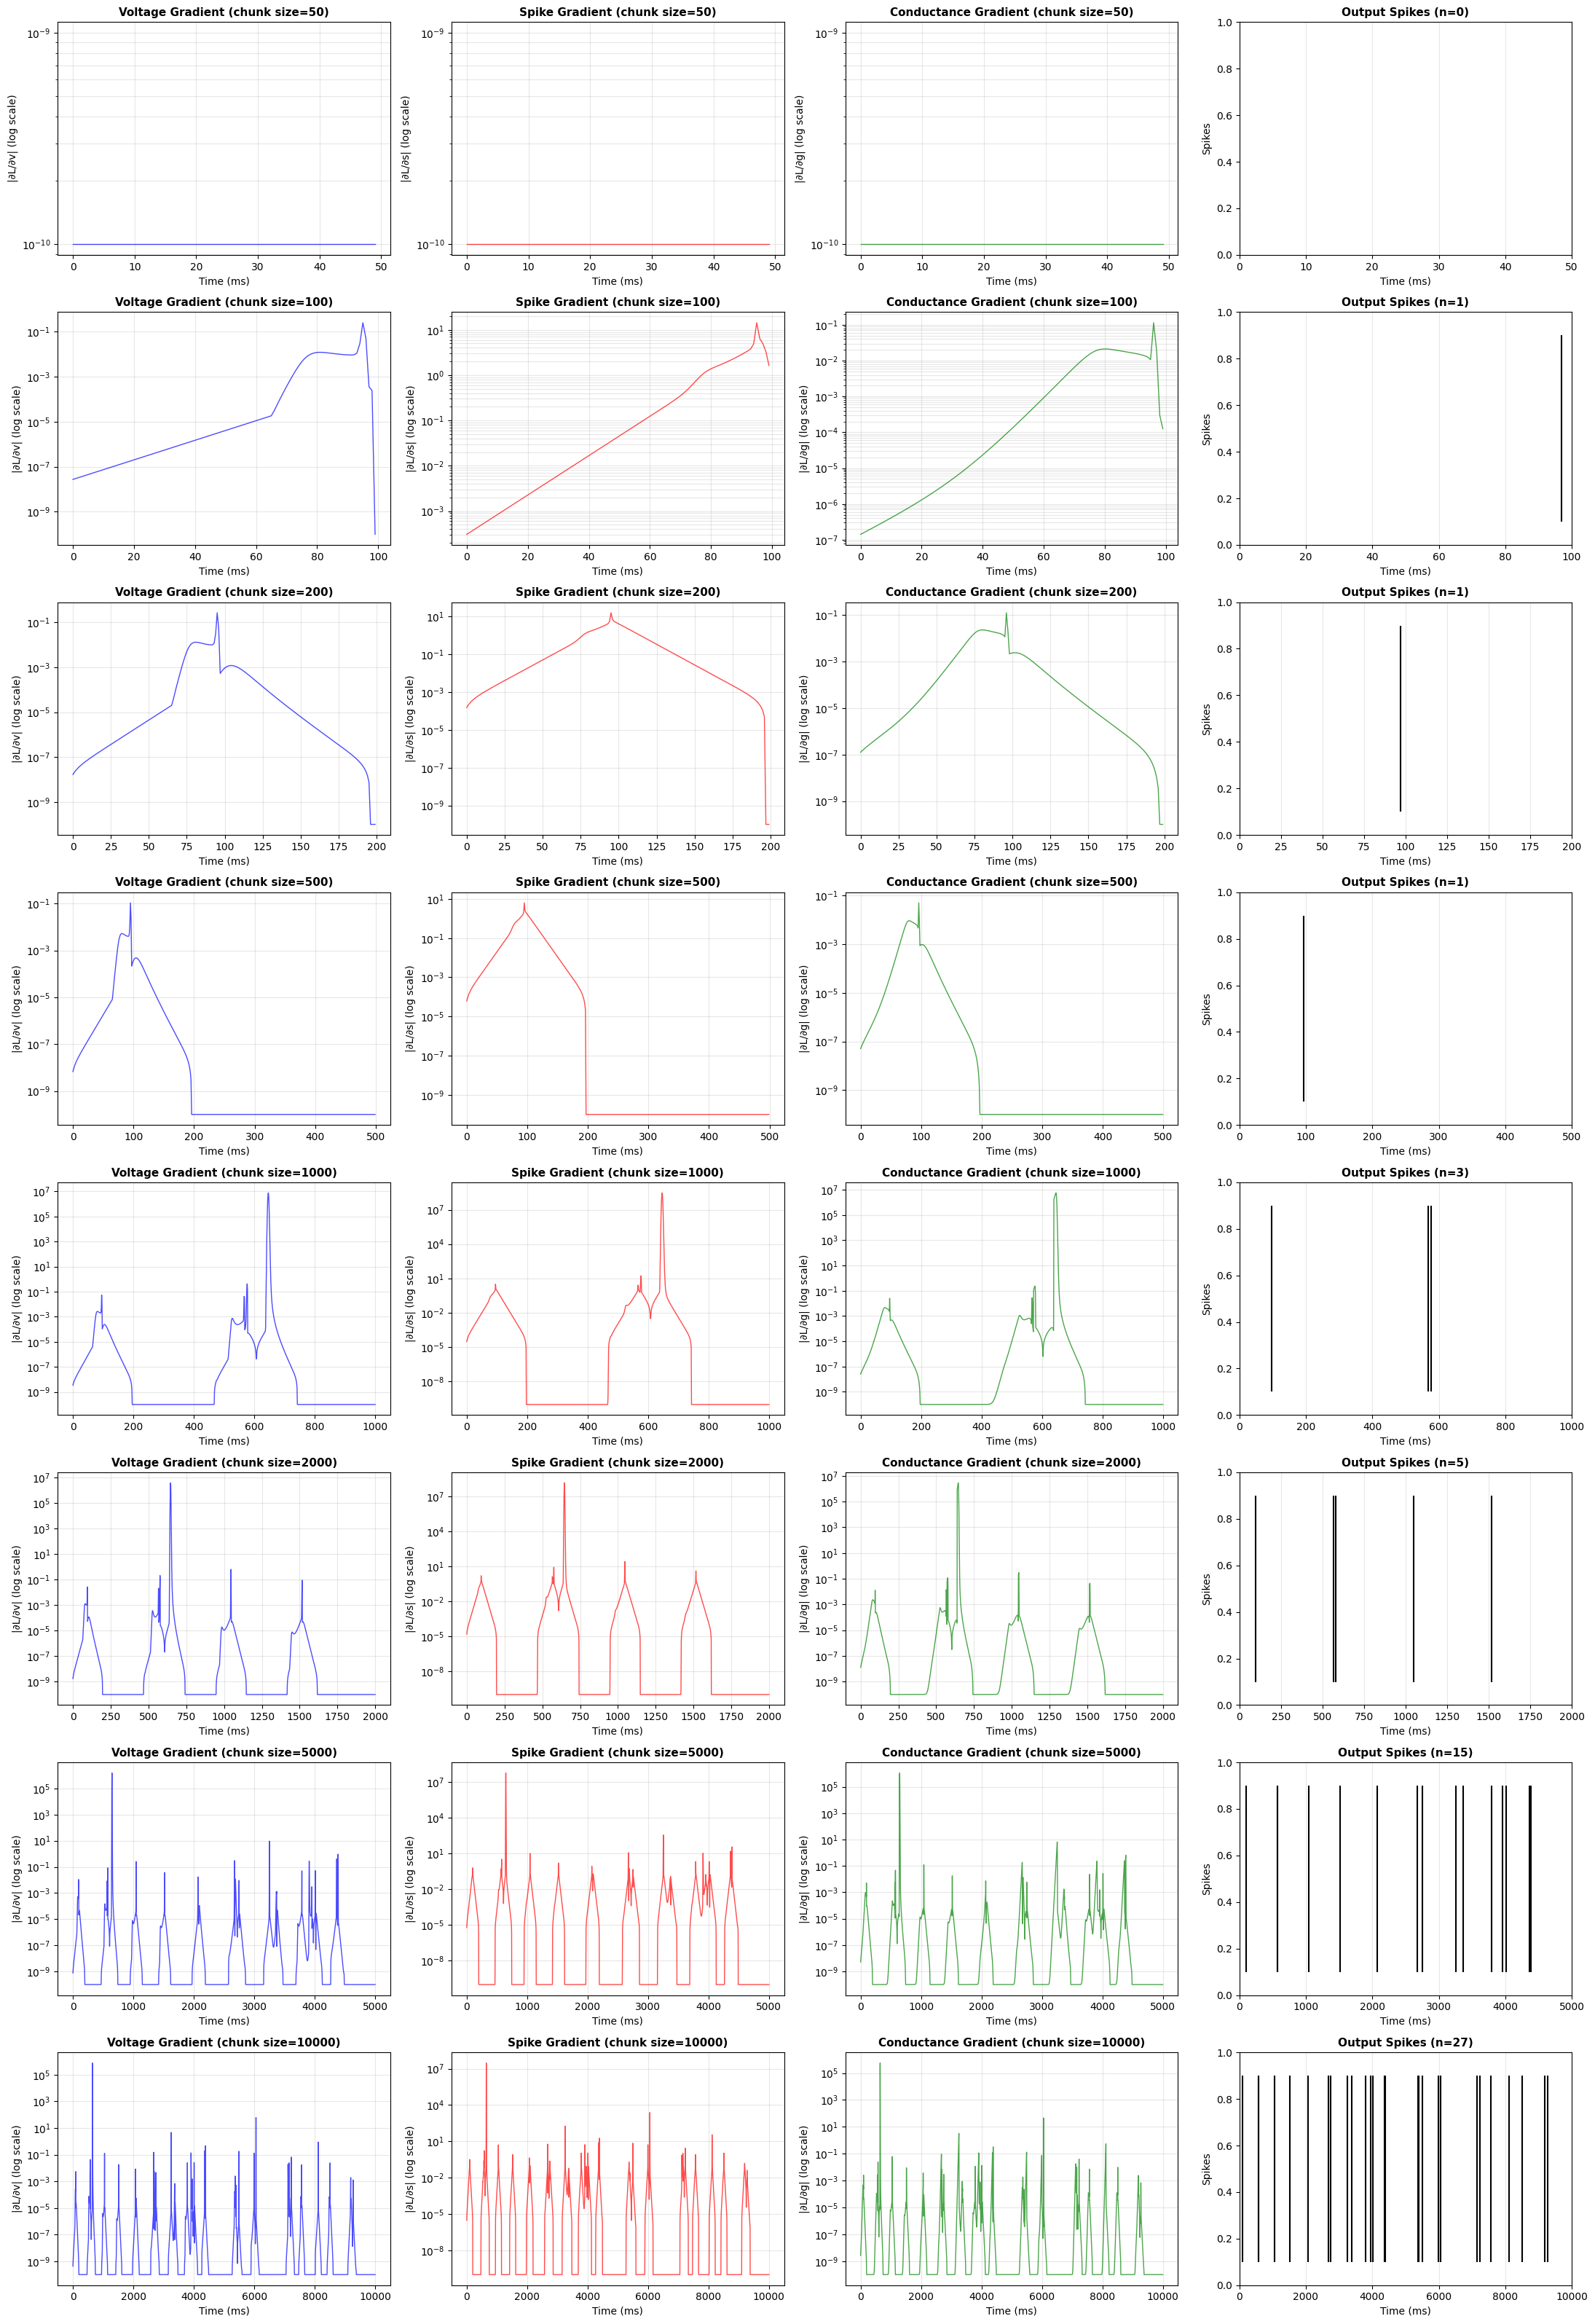


Analysis complete!


In [20]:
# Analyze voltage/spike/conductance gradients for decay-only model across time
print(
    "Analyzing voltage/spike/conductance gradients over time (DECAY-ONLY CONDUCTANCE MODEL)"
)
print("=" * 70)

# Test a few different chunk sizes
chunk_sizes_to_test_decay = [50, 100, 200, 500, 1000, 2000, 5000, 10000]

fig, axes = plt.subplots(
    len(chunk_sizes_to_test_decay), 4, figsize=(22, 4 * len(chunk_sizes_to_test_decay))
)

for idx, chunk_size_steps in enumerate(chunk_sizes_to_test_decay):
    print(f"\nProcessing chunk size: {chunk_size_steps}")

    # Create fresh model for each iteration
    grad_model_decay = FeedforwardConductanceDecayOnlyLIFNetwork(
        dt=dt,
        weights_FF=np.array([[1.0]]),
        cell_type_indices=cell_type_indices,
        cell_type_indices_FF=cell_type_indices,
        cell_params=params.recurrent.get_cell_params(),
        cell_params_FF=params.feedforward.get_cell_params(),
        synapse_params_FF=[
            {
                "name": "excitatory",
                "synapse_id": 0,
                "cell_id": 0,
                "tau_decay": 5.0,
                "E_syn": 0.0,
                "g_bar": 10.0,
            }
        ],
        surrgrad_scale=surrgrad_scale,
        batch_size=1,
        optimisable="weights",
        feedforward_mask=feedforward_mask,
        track_variables=False,
        track_gradients=True,
        use_tqdm=False,
    )

    # Reset Van Rossum loss
    van_rossum_loss_fn = VanRossumLoss(
        tau=params.hyperparameters.van_rossum_tau,
        dt=dt,
        window_size=100,
        device="cpu",
    )

    # Get data - use multiple chunks if needed for larger sizes
    num_chunks_needed = (chunk_size_steps + 999) // 1000  # Ceiling division
    input_data_list = []
    target_data_list = []
    for chunk_idx in range(num_chunks_needed):
        if chunk_idx < len(spike_dataset):
            inp, tgt = spike_dataset[chunk_idx]
            input_data_list.append(inp)
            target_data_list.append(tgt)

    input_data = torch.cat(input_data_list, dim=1)
    target_data = torch.cat(target_data_list, dim=1)

    # Extract subset of chunk
    input_subset = input_data[:, :chunk_size_steps, :]
    target_subset = target_data[:, :chunk_size_steps, :]

    # Run forward pass with gradient tracking
    output_spikes = grad_model_decay(input_subset)

    # Compute loss
    loss = 100 * van_rossum_loss_fn(output_spikes, target_subset)

    # Compute gradients
    loss.backward()

    # Extract tracked gradients
    grads = grad_model_decay.get_tracked_gradients()

    # Extract voltage, spike, and conductance gradients over time
    v_grads = grads["grad_v"][:, 0, 0].cpu().numpy()
    s_grads = grads["grad_s"][:, 0, 0].cpu().numpy()
    g_grads = (
        grads["grad_g_FF"][:, 0, 0, 0].cpu().numpy()
    )  # decay component only, first synapse type
    spikes = output_spikes[:, :, 0].detach().cpu().numpy().flatten()
    times = np.arange(chunk_size_steps)

    # Check for NaNs
    n_nan_v = np.sum(np.isnan(v_grads))
    n_nan_s = np.sum(np.isnan(s_grads))
    n_nan_g = np.sum(np.isnan(g_grads))
    n_zero_v = np.sum(v_grads == 0)
    n_zero_s = np.sum(s_grads == 0)
    n_zero_g = np.sum(g_grads == 0)
    n_spikes = np.sum(spikes > 0.5)
    spike_times = np.where(spikes > 0.5)[0]

    # Plot voltage gradients (absolute value on log scale)
    ax = axes[idx, 0]
    ax.plot(times, np.abs(v_grads) + 1e-10, "b-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂v| (log scale)", fontsize=10)
    ax.set_title(
        f"Voltage Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot spike gradients (absolute value on log scale)
    ax = axes[idx, 1]
    ax.plot(times, np.abs(s_grads) + 1e-10, "r-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂s| (log scale)", fontsize=10)
    ax.set_title(
        f"Spike Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot conductance gradients (absolute value on log scale)
    ax = axes[idx, 2]
    ax.plot(times, np.abs(g_grads) + 1e-10, "g-", linewidth=1, alpha=0.7)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("|∂L/∂g| (log scale)", fontsize=10)
    ax.set_title(
        f"Conductance Gradient (chunk size={chunk_size_steps})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both")

    # Plot spikes
    ax = axes[idx, 3]
    if len(spike_times) > 0:
        ax.eventplot(
            [spike_times], lineoffsets=0.5, linelengths=0.8, colors="k", linewidths=1.5
        )
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("Spikes", fontsize=10)
    ax.set_title(f"Output Spikes (n={n_spikes})", fontsize=11, fontweight="bold")
    ax.set_xlim(0, chunk_size_steps)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis="x")

    print(f"  Loss: {loss.item():.6f}")
    print(f"  Max |∂L/∂v|: {np.max(np.abs(v_grads)):.8f}")
    print(f"  Max |∂L/∂s|: {np.max(np.abs(s_grads)):.8f}")
    print(f"  Max |∂L/∂g|: {np.max(np.abs(g_grads)):.8f}")
    print(f"  Number of spikes: {n_spikes}")
    print(
        f"  NaNs - v: {n_nan_v}/{len(v_grads)}, s: {n_nan_s}/{len(s_grads)}, g: {n_nan_g}/{len(g_grads)}"
    )
    print(
        f"  Zeros - v: {n_zero_v}/{len(v_grads)}, s: {n_zero_s}/{len(s_grads)}, g: {n_zero_g}/{len(g_grads)}"
    )
    print(
        f"  Non-zero non-NaN - v: {len(v_grads) - n_zero_v - n_nan_v}, s: {len(s_grads) - n_zero_s - n_nan_s}, g: {len(g_grads) - n_zero_g - n_nan_g}"
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Analysis complete!")

In [21]:
# Print teacher spike statistics
print("Teacher Spike Statistics")
print("=" * 70)
print(f"Total timesteps: {output_spikes.shape[1]}")
print(f"Total teacher spikes: {output_spikes.sum().item():.0f}")
print(
    f"Teacher firing rate: {output_spikes.sum().item() / (output_spikes.shape[1] * dt) * 1000:.2f} Hz"
)
print("\nPer-chunk breakdown:")
for chunk_idx in range(spike_dataset.num_chunks):
    _, target_chunk = spike_dataset[chunk_idx]
    n_spikes = target_chunk.sum().item()
    print(
        f"  Chunk {chunk_idx}: {n_spikes:.0f} spikes ({n_spikes / chunk_size * 1000:.2f} Hz)"
    )
print("=" * 70)

Teacher Spike Statistics
Total timesteps: 10000
Total teacher spikes: 27
Teacher firing rate: 2.70 Hz

Per-chunk breakdown:
  Chunk 0: 2 spikes (2.00 Hz)
  Chunk 1: 0 spikes (0.00 Hz)
  Chunk 2: 3 spikes (3.00 Hz)
  Chunk 3: 2 spikes (2.00 Hz)
  Chunk 4: 2 spikes (2.00 Hz)
  Chunk 5: 2 spikes (2.00 Hz)
  Chunk 6: 1 spikes (1.00 Hz)
  Chunk 7: 1 spikes (1.00 Hz)
  Chunk 8: 0 spikes (0.00 Hz)
  Chunk 9: 1 spikes (1.00 Hz)
  Chunk 10: 1 spikes (1.00 Hz)
  Chunk 11: 0 spikes (0.00 Hz)
  Chunk 12: 1 spikes (1.00 Hz)
  Chunk 13: 6 spikes (6.00 Hz)
  Chunk 14: 0 spikes (0.00 Hz)
  Chunk 15: 1 spikes (1.00 Hz)
  Chunk 16: 0 spikes (0.00 Hz)
  Chunk 17: 5 spikes (5.00 Hz)
  Chunk 18: 5 spikes (5.00 Hz)
  Chunk 19: 1 spikes (1.00 Hz)
